# Analyze Kalman Filter vs Ground Truth from iPhone localization to estimate bot performance under dead-reckoning

Datasets were gathered by affixing an iPhone 14 to a large selfie stick, pointing it downwards, and walking in various locations. Below we'll explore data gathered on the sidewalks of Frazier Rogers and Malachowski hall.

The data gathered includes location data at a rate of 1hz from the iPhone location API (which preemptively fuses readings from cellular signal strength, GPS location, GPS doppler shift, and internal barometer data)
We take this a step further, applying a simple linear kalman filter to fuse 100hz IMU data, which is first transformed from phone axes using iPhone orientation data polled at the same rate. 

iPhone documentation places IMU inaccuracy at 1%, which we accordingly apply in our Kalman filter. Significant manual tweaking was performed to identify appropriate parameters.

Additionally, COLMAP was used to obtain both a high density pointcloud of the terrain the iPhone's camera captured, and camera extrinsics.

COLMAP operates on our ~4000 frame video gathered over the course of two minutes, while the Kalman filter's dead reckoning outputs closer to 14000 data points. In order to improve colmap convergence, data was downsampled to ~700 frames, and specific frames containing bad imagery (the feet of those carrying the selfie stick, passing cars, etc) were manually removed. This in turn required a manual correction to the interpolation of camera poses for those missing frames, which was performed by hand in Blender in as consistent a manner as possible. For instance, if three frames from frame 500 to frame 503 were manually removed, COLMAP would output a camera trajectory that rapidly teleports accross this gap. Remedying this requires that the camera pose curves downstream of ommitted frames are shifted forward in time by interpolating over the time gap created by the ommission.

Below, we import these corrected trajectories from Blender. We will perform Procrustes Superimposition, a technique to optimally align the shapes of our Kalman and COLMAP output camera trajectories. We then perform analysis on the residuals (MSE, PSNR, inf-norm).

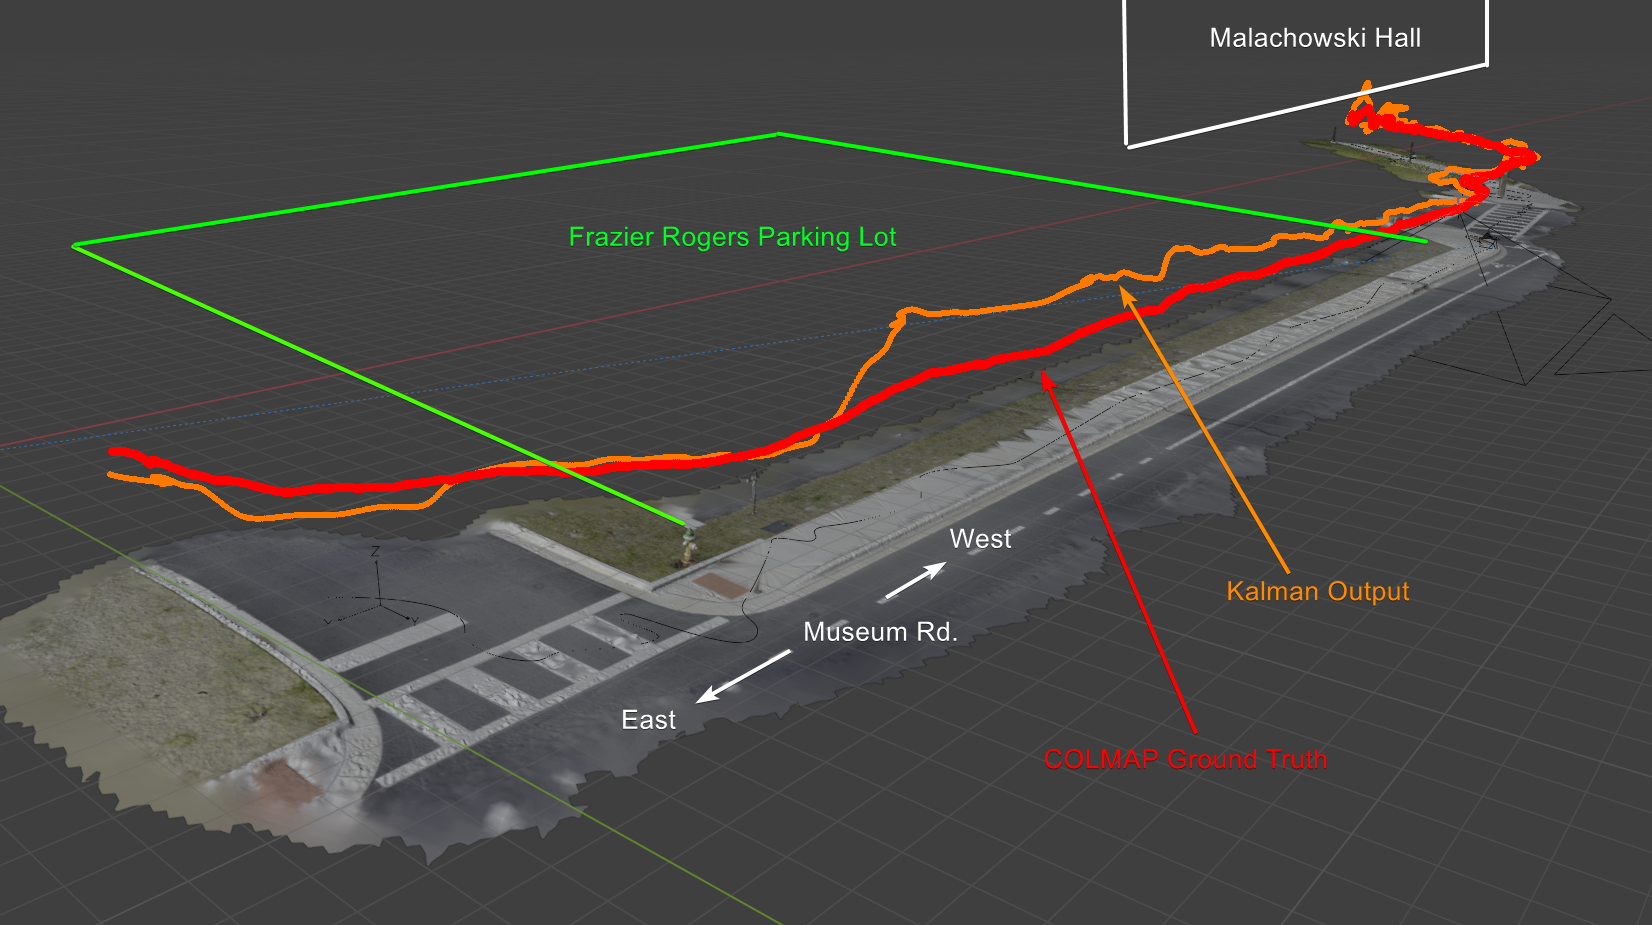

Astute readers will point out that a Kalman filter begins with significant uncertainty, and converges on absolute estimates of position, regardless of initial condition. That is, if we have absolute location data (and we do, in GPS coordinates), then one should expect the Kalman filter to converge on these. Why, then, must we perform this additional superimposition step below? Unfortunately, obtaining or establishing a principal point when performing structure from motion is an ill-posed problem, and COLMAP outputs camera trajectories and pointcloud transforms in an arbitrary coordinate space (in our case, misaligned, poorly scaled, and upside down). Correction was done manually for visualization purposes in blender. Tools exist to align the pointcloud with known GPS data, but we are hesitant to attempt such an alignment, as we have not formally performed surveying of the land as one might with an RTK system before a construction project. Additionally, while such alignment is beneficial for a pointcloud, it performs a nonlinear transformation on it and the resulting mesh, but software that enables this corrective postprocessing is agnostic to the camera trajectories and does not attempt to adjust them. As camera trajectories are our primary comparison of interest, this postprocessing step is therefore useless.

We are unprepared to rewrite elements of the COLMAP library, MeshLab, or alternative closed-source (and expensive) solutions, and so are resigned to the analysis below, which makes the assumption that the best possible alignment of the ground truth and Kalman data within an arbitary coordinate space will position the ground truth data such that it is aligned to the best average estimate of absolute position given by the Kalman filter. Additionally, by trimming the first 10 seconds of data or so (which involved positioning and extending the stick and are insignificant to us), we give the kalman sensor time to converge. Not pictured in the above image is a noisy path representing these 10 seconds on the left end of the orange trajectory. This is truncated, ensuring the below analysis does indeed align to relatively accurate absolute positional data.

In [21]:
import numpy as np
import pandas as pd
import plotly.express as px

from scipy.linalg import orthogonal_procrustes

# Load the CSV file
csv_file_path = 'C:/Users/c1a55/Documents/Roborouter/Notebooks/BlenderTrajectories.csv'
df = pd.read_csv(csv_file_path)

# Separate the data for each camera
kalman_data = df[df['Sensor'] == 'KALMAN'][['Position X', 'Position Y', 'Position Z']].to_numpy()
colmap_data = df[df['Sensor'] == 'COLMAP'][['Position X', 'Position Y', 'Position Z']].to_numpy()

# Step 1: Translation adjustment (Center the datasets)
centroid_kalman = np.mean(kalman_data, axis=0)
centroid_colmap = np.mean(colmap_data, axis=0)
kalmanCentered = kalman_data - centroid_kalman
colmapCentered = colmap_data - centroid_colmap
# Procrustes analysis (no scaling)
Rot, scale = orthogonal_procrustes(colmap_data, kalman_data)

# Apply the rotation matrix R to data_a_centered
colmapAligned = colmapCentered.dot(Rot)
residuals = colmapAligned - kalmanCentered
norms = np.linalg.norm(residuals, axis=1)
# Calculate MSE
mse = np.mean(norms**2)

# Calculate Max Error (Infinity Norm)
max_error = np.max(norms)

df_aligned = pd.DataFrame({
    "Aligned COLMAP X": colmapAligned[:, 0],
    "Aligned COLMAP Y": colmapAligned[:, 1],
    "Aligned COLMAP Z": colmapAligned[:, 2],
    "KALMAN X": kalmanCentered[:, 0],
    "KALMAN Y": kalmanCentered[:, 1],
    "KALMAN Z": kalmanCentered[:, 2]
})

# Plotting
fig = px.line_3d(df_aligned, x='Aligned COLMAP X', y='Aligned COLMAP Y', z='Aligned COLMAP Z', color_discrete_sequence=['red'], labels={'value': 'Aligned COLMAP Path'})
fig.add_scatter3d(x=df_aligned['KALMAN X'], y=df_aligned['KALMAN Y'], z=df_aligned['KALMAN Z'], mode='lines', name='KALMAN Path', line=dict(color='blue'))
fig.update_layout(title="3D Paths of Aligned COLMAP and KALMAN Data")
fig.layout.scene.aspectmode='data'
fig.show()

psnr = 20 * np.log10(max_error / np.sqrt(mse))

display(mse, max_error, psnr)

1.807011688703424

4.292246972117963

10.08408444055739

PSNR is telling, and though typically used in images, is an insightful metric here in that while the mean square error is minimal, the max deviation is indeed significant.\
All values are computed in terms of meters. This is validated by comparing known real life distances to blender's units, ensuring they line up (they do!) COLMAP is fitted to Kalman data, not the other way around, further ensuring our units are consistent with real life measurements and not arbitrary hand-scaling for visualization in blender.

This MSE of 1.8m is indicative of the expected challenges of dead reckoning. It is also orders of magnitude worse than drone-grade GPS sensor and IMU data typically found on development kits. Regardless, it still highlights the significance of a technique like VSLAM, Visual Simultaneous Localization and Mapping, which enables corrections to be made based on optical flow. We are able to obtain such corrections when stitching reprojected images, but are unable to test the efficacy of these measures in a real environment. In our simulated environment, we use known camera poses for each frame and do not attempt localization. This is because our project emphasizes innovations in pathfinding and planning, not localization, which is already well understood and implemented by several publicly available ROS packages.

Our project's aim is to identify and segment inconvenient surfaces to navigate around. This works in conjunction with other sensors, like LIDaR, which identifies ankle-height and larger obstacles. ROS collects "collisions" / obstacles detected by other sensors like LiDAR and performs its own vSLAM, fusing position data. This forms a 2D top-down "costmap". These sensors are not well-suited for mapping the surface of terrain in front of the robot. Since this costmap is already localized to the robot (the robot understands its own motion relative to the map), our sole objective is to integrate our own bad-surface-detection with this costmap, inserting false collisions / obstacles as needed. All pathfinding is then handled downstream of this costmap, using A* with a heuristic that attempts to maximize distance from nearest walls (e.g., centering oneself in a hallway).

# Simulating a Virtual Drone at the Steps of Malachowski:
Below, we process a virtual drone's perspective driving along a predetermined path in front of Malachowski hall. We reuse the same code we've integrated with ROS, but without the limitations created by our development kit's unfortunate sensors, sunlight IR interference, and other issues. Instead, we assume an ideal depth and color sensor at a slightly resolution than that which the bot provides (640x480 vs our 512x512). We also use known positions drone positions in order to isolate localization concerns which are not our project's purpose. HOWEVER, we do not use the known location to perform image stitching, relying instead on feature matching / optical flow algorithms, in order to demonstrate the robustness of our approach, which is robust when faced with localization noise.